# CNN

In [ ]:
from collections import Counter
import os
import warnings

import cv2 as cv
import matplotlib.pyplot as plt
# Importing all necessary libraries
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


warnings.filterwarnings('ignore')

# What does our image data look like?

In [ ]:
# A little bit of data exploration
path = 'input/PokemonData' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

Let's break our pokemon data into two halves.  Sending to many images to our classifier will make it take a long time.

## First Half of pokemon images we have.

In [ ]:
# Sort our "counts" dictionary and selecting 5 classes with most number of images
combined = sorted(counts.items(), key = lambda x: x[1], reverse = True)
print(combined)

# Taking only labels, it will come in handy in future
combined = [i[0] for i in combined]
print(combined)

Venusaur, Pikachu, Snorlax, Vaporeon and Scyther are the Pokemon that we have the most images for.  

Next we'll attempt to remove images that won't process well.

In [ ]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'first_half' list
    if c in combined:
        dir_path = os.path.join(path, c)
        label = combined.index(c) # Our label is an index of class in 'first_half' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) 
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

In [ ]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (60, 5))
sns.barplot(x = [combined[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images per pokemon')
plt.margins(x=0)
plt.xticks(rotation=45)
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(combined))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

Use data augmentation to provide even more images.

In [ ]:
# Defining ImageDataGenerator Instance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
img = X[300]
img = img.reshape([-1, 96, 96, 3])

i = 0
fig_check = plt.figure(figsize = (18, 8))

for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
    fig_check.add_subplot(2, 5, i+1)
    plt.imshow(np.squeeze(flow[:, :, ::-1]))
    plt.axis('off')
    i += 1
    if i >= 10:
        break

# Build the model

In [ ]:
len(combined)

In [ ]:
model = keras.Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(combined), activation = 'softmax'))

model.summary()

In [51]:
checkpoint = ModelCheckpoint('working/best_model_combined.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size = 32), epochs = 60, validation_data = [X_test, y_test],
                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

Epoch 4/60
170/170 [==============================] - ETA: 0s - loss: 3.6422 - accuracy: 0.1284
Epoch 4: val_accuracy improved from 0.15678 to 0.21538, saving model to working/best_model_combined.hdf5
170/170 [==============================] - 209s 1s/step - loss: 3.6422 - accuracy: 0.1284 - val_loss: 3.0853 - val_accuracy: 0.2154
Epoch 5/60
170/170 [==============================] - ETA: 0s - loss: 3.4428 - accuracy: 0.1498
Epoch 5: val_accuracy improved from 0.21538 to 0.27692, saving model to working/best_model_combined.hdf5
170/170 [==============================] - 201s 1s/step - loss: 3.4428 - accuracy: 0.1498 - val_loss: 2.7765 - val_accuracy: 0.2769
Epoch 6/60
170/170 [==============================] - ETA: 0s - loss: 3.2798 - accuracy: 0.1852
Epoch 6: val_accuracy improved from 0.27692 to 0.31062, saving model to working/best_model_combined.hdf5
170/170 [==============================] - 223s 1s/step - loss: 3.2798 - accuracy: 0.1852 - val_loss: 2.5585 - val_accuracy: 0.3106
E

In [ ]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [53]:
# Loading weights from best model
model.load_weights('working/best_model_combined.hdf5')

# Saving all model
model.save('working/combined_model.hdf5')

In [54]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]
test_df

[['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
  'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
  'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg'],
 ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
  'https://johnlewis.scene7.com/is/image/JohnLewis/237525467'],
 ['https://img.pokemondb.net/artwork/large/charmander.jpg',
  'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
  'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg'],
 ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
  'https://ae01.alicdn.com/kf/HTB1aWullxSYBu

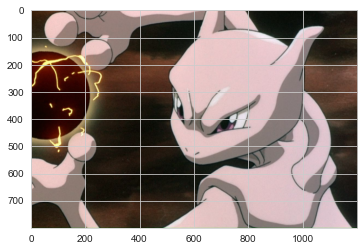

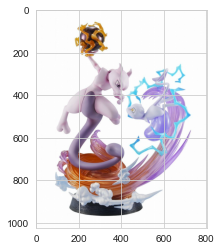

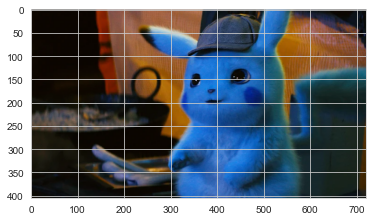

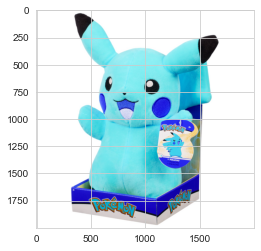

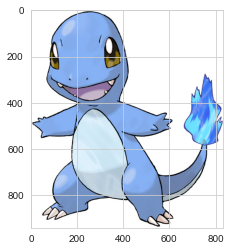

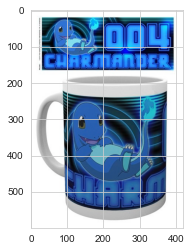

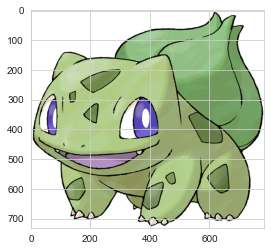

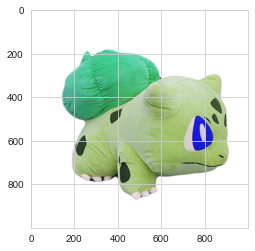

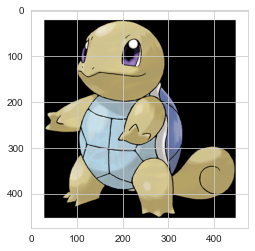

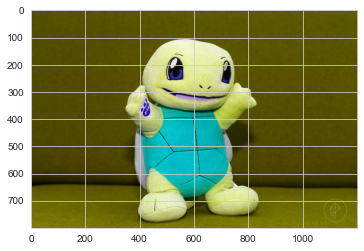

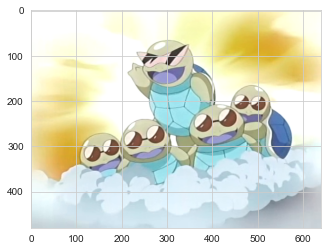

In [55]:
import requests

# Lists to store our future data
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv.imdecode(image, cv.IMREAD_COLOR)

        if (image is not None):
            val_x.append(image)
            val_y.append(i)

            plt.imshow(image)
            plt.show()

# Predictions

0
1/1 [==============================] - 0s 214ms/step
0
1/1 [==============================] - 0s 275ms/step
1
1/1 [==============================] - 0s 227ms/step
1
1/1 [==============================] - 0s 239ms/step
2
1/1 [==============================] - 0s 203ms/step
2
1/1 [==============================] - 0s 217ms/step
3
1/1 [==============================] - 0s 197ms/step
3
1/1 [==============================] - 0s 192ms/step
4
1/1 [==============================] - 0s 196ms/step
4
1/1 [==============================] - 0s 197ms/step
4
1/1 [==============================] - 0s 222ms/step


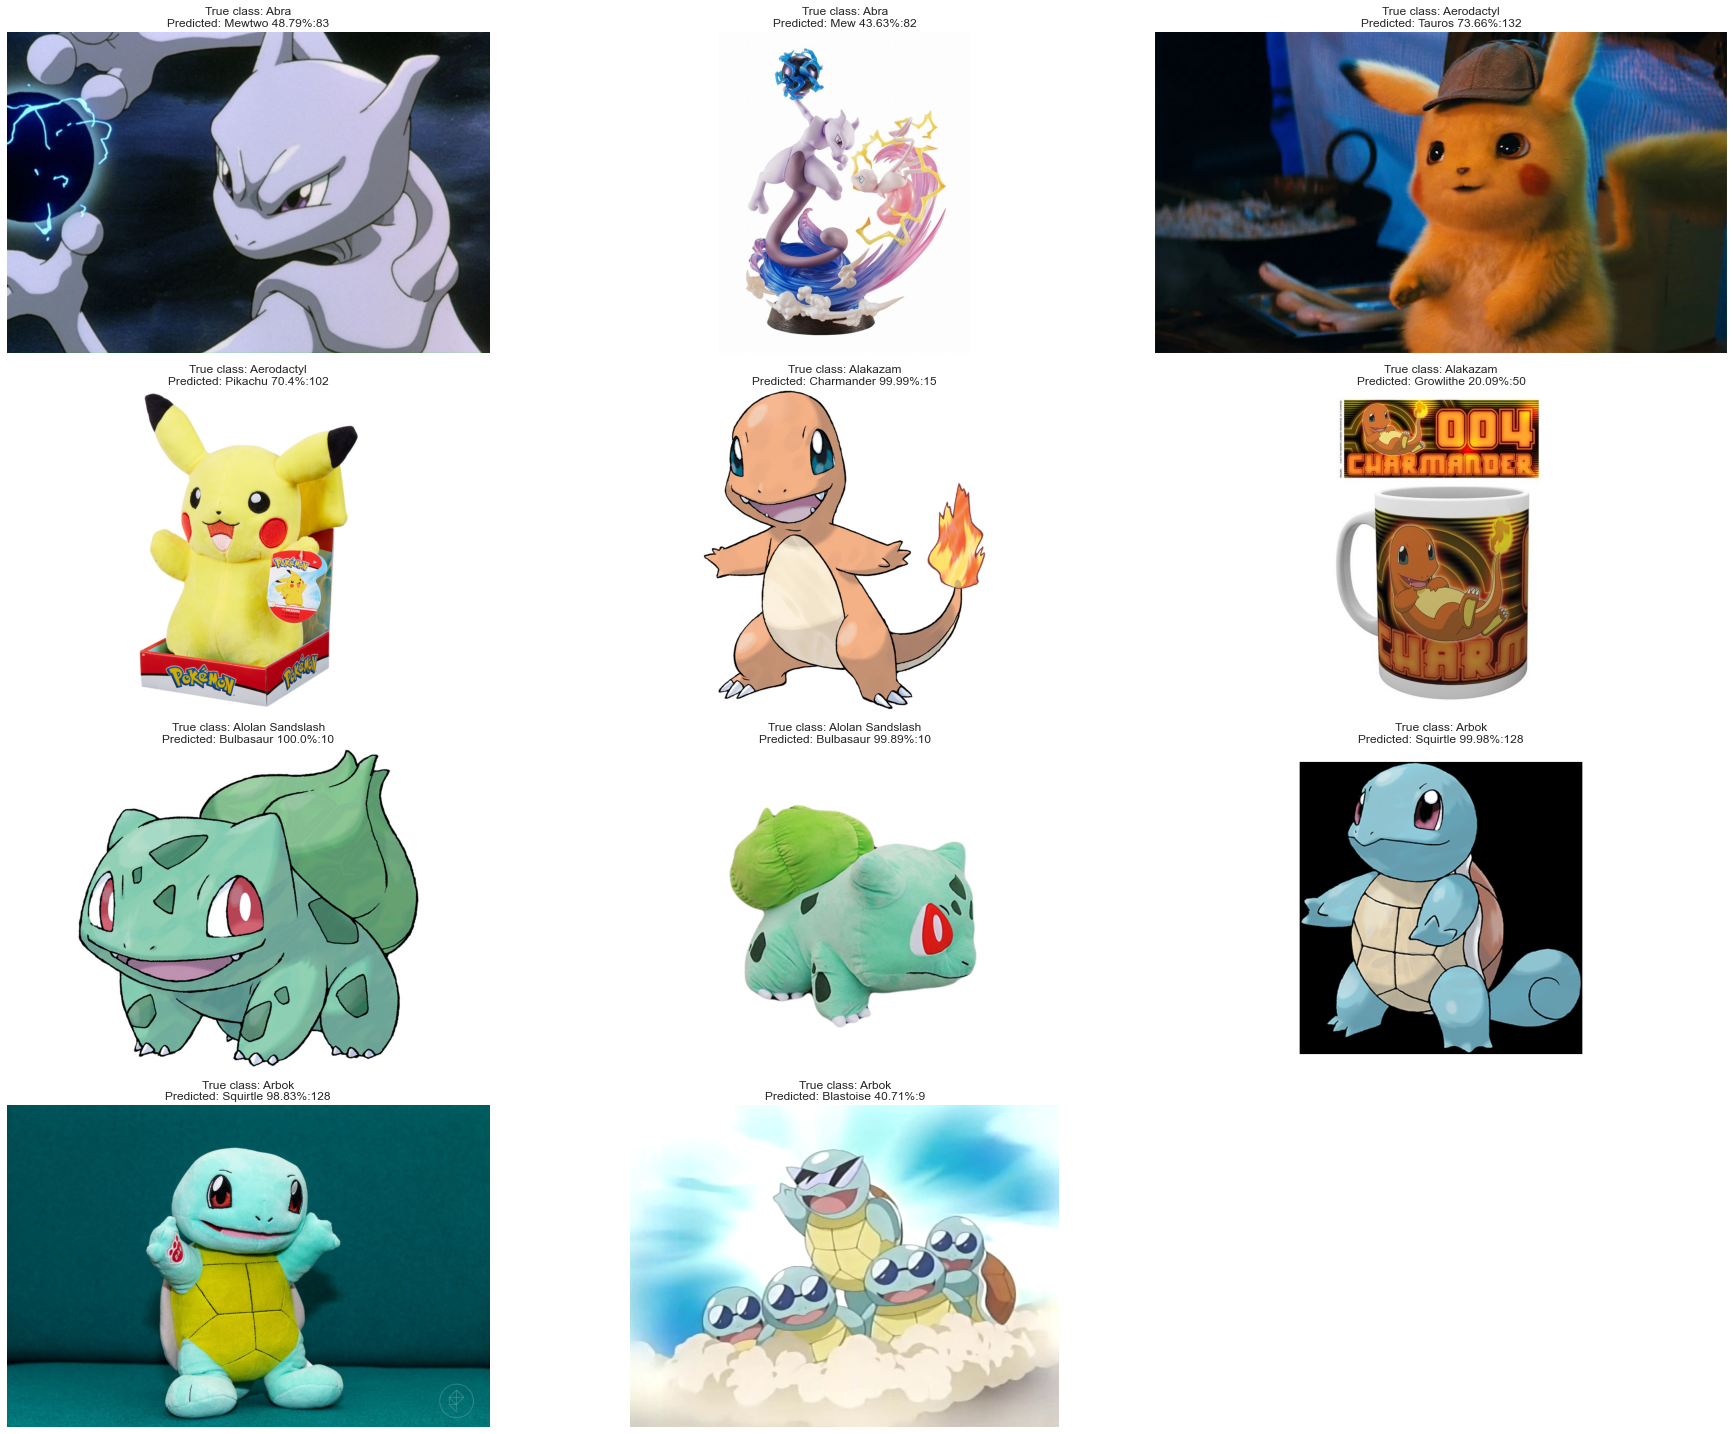

In [66]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 25))

for i, j in enumerate(zip(val_x, val_y)): # i - for subplots
    orig = j[0] # Original, not resized image
    label = j[1] # Label for that image
    print(label)

    image = cv.resize(orig, (96, 96)) # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0 # Reshape and scale resized image
    this_model = load_model('app/model/model.hdf5')
    preds = this_model.predict(image) # Predicting image
    pred_class = np.argmax(preds) # Defining predicted class

    true_label = f'True class: {combined[label]}'
    pred_label = f'Predicted: {combined[pred_class]} {round(preds[0][pred_class] * 100, 2)}%'

    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title(f'{true_label}\n{pred_label}:{pred_class}')
    plt.axis('off')

plt.tight_layout()

# Is it possible to continue training a previously trained model? Yes!

In [57]:


new_training = load_model('working/combined_model.hdf5')
new_history = model.fit(datagen.flow(X_train, y_train, batch_size = 32), epochs = 60, validation_data = [X_test, y_test],
                             steps_per_epoch=len(X_train) // 32, callbacks = [checkpoint])

Epoch 1/60
170/170 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.7301
Epoch 1: val_accuracy did not improve from 0.78535
170/170 [==============================] - 159s 933ms/step - loss: 0.8903 - accuracy: 0.7301 - val_loss: 0.8780 - val_accuracy: 0.7795
Epoch 2/60
170/170 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.7378
Epoch 2: val_accuracy did not improve from 0.78535
170/170 [==============================] - 159s 932ms/step - loss: 0.9028 - accuracy: 0.7378 - val_loss: 0.8613 - val_accuracy: 0.7685
Epoch 3/60
170/170 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.7467
Epoch 3: val_accuracy did not improve from 0.78535
170/170 [==============================] - 158s 929ms/step - loss: 0.8751 - accuracy: 0.7467 - val_loss: 0.8305 - val_accuracy: 0.7846
Epoch 4/60
170/170 [==============================] - ETA: 0s - loss: 0.8029 - accuracy: 0.7603
Epoch 4: val_accuracy did not improve from 0.78535
170/170

# How much did that improve the accuracy/loss?

Text(0.5, 1.0, 'loss')

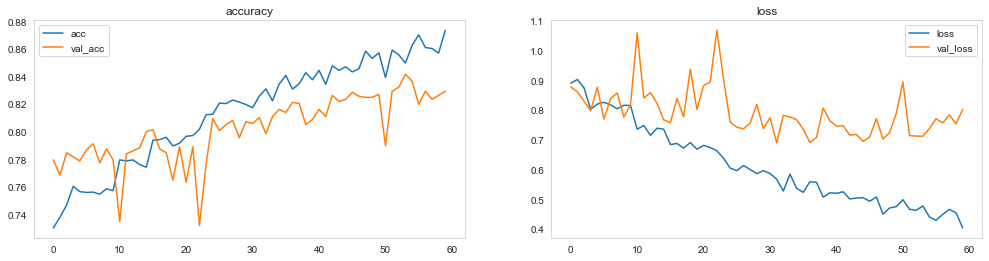

In [61]:
# Plot learning curves
fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(new_history.history['accuracy'], label = 'acc')
plt.plot(new_history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(new_history.history['loss'], label = 'loss')
plt.plot(new_history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

## About 10% accuracy improvement / negligable loss improvement

In [62]:
# Loading weights from best model
model.load_weights('working/best_model_combined.hdf5')

# Saving all model
model.save('working/combined_model.hdf5')